#Importar data de pacientes

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
df_filt1=pd.read_csv('df_filt1.csv')
df_filt1

,subject_id,weight,height,age,Anestesia_TIME,Operation_TIME,UCI_TIME,Survival Rate,rr,nibp_sbp,...,hr,art_dbp,art_mbp,etco2,fio2,bt,hs,uo,ebl,peep
0,192250700,59.0,163.0,65,380.0,340.0,2345.0,0,9.519231,104.617021,...,95.714286,52.346667,66.181818,30.506757,53.297297,34.727778,166.666667,410.0,500.000000,2.194805
1,131682281,56.0,156.0,30,195.0,165.0,0.0,0,9.085714,120.000000,...,53.166667,70.529412,91.705882,30.471429,46.068571,36.343750,380.000000,72.5,125.000000,2.028571
2,187096493,49.0,159.0,35,240.0,200.0,0.0,0,9.734043,125.857143,...,78.833333,71.043478,94.826087,30.636364,46.840909,36.476190,333.333333,15.0,133.333333,0.042553
3,189326404,70.0,162.0,65,130.0,105.0,0.0,0,10.820000,132.583333,...,93.666667,67.636364,82.583333,34.227273,44.181818,32.095652,110.000000,120.0,125.000000,0.130435
4,152129940,46.0,151.0,60,125.0,100.0,0.0,0,9.120000,138.333333,...,57.076923,68.695652,93.565217,32.195652,51.391304,35.436364,94.444444,55.0,95.000000,0.086957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,107979743,49.0,158.0,20,125.0,75.0,0.0,0,10.000000,110.166667,...,76.074074,64.869565,71.407407,27.750000,45.100000,35.795000,175.000000,90.0,40.000000,4.750000
412,134061920,60.0,174.0,80,350.0,305.0,795.0,0,14.461538,124.000000,...,53.565217,47.121212,69.666667,36.861538,33.938462,35.674194,150.000000,130.0,177.777778,5.107692
413,192891843,64.0,158.0,50,115.0,85.0,0.0,0,9.847826,145.875000,...,73.148936,78.095238,98.545455,31.500000,44.333333,36.341176,300.000000,50.0,70.000000,4.695652
414,178121234,60.0,158.0,70,255.0,215.0,0.0,0,10.673077,134.200000,...,52.761905,56.117647,76.039216,31.596154,42.748000,36.169565,100.000000,50.0,55.000000,2.076923


In [3]:
# Crear una copia de la columna
df1 = df_filt1[['UCI_TIME']].copy()

# Clasificar los valores según las condiciones (De 0 a 7000 : tiempo corto(0),De  7000 a 14000 -tiempo mediano(1)- Mayor a 14000-tiempo largo en UCI (2)
df1['UCI_TIME'] = df1['UCI_TIME'].apply(lambda x: 0 if x <= 7000 else (1 if x <= 14000 and x>7000 else 2))

# Mostrar el DataFrame resultante
conteo1=df1['UCI_TIME'].value_counts()
conteo1

#new_df = operation_pac[['subject_id','icuin_time', 'icuout_time', 'inhosp_death_time']].copy()
#difference=(operation_pac['icuout_time'] - operation_pac['icuin_time'])

UCI_TIME
0    403
1      9
2      4
Name: count, dtype: int64

#Modelos ML

In [28]:
# Preparación de los datos
X = df_filt1.drop(columns=['UCI_TIME', 'Survival Rate', 'subject_id','weight','height','age','Anestesia_TIME','Operation_TIME'])
#X = df_filt1.drop(columns=['UCI_TIME', 'Survival Rate', 'subject_id'])
y = df1['UCI_TIME']

# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


########################################
# Crear una tubería que combine SMOTE y RandomUnderSampler
over = SMOTE(sampling_strategy={1: 150, 2:100}, random_state=42, k_neighbors=2)
under = RandomUnderSampler(sampling_strategy={0: 200}, random_state=42)
pipeline = Pipeline(steps=[('o', over), ('u', under)])


# Aplicar la tubería a los datos
X_resampled, y_resampled = pipeline.fit_resample(X_scaled, y)

# Convertir las etiquetas a formato categórico
y_categorical = to_categorical(y_resampled, num_classes=3)
######################################
# Aplicar SMOTE Tomek para sobremuestrear las clases minoritarias y limpiar los ejemplos
#smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42, smote=SMOTE(k_neighbors=2))
#X_resampled, y_resampled = smote_tomek.fit_resample(X_scaled, y)

# Convertir las etiquetas a formato categórico
#y_categorical = to_categorical(y_resampled, num_classes=3)
########################################

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_categorical, test_size=0.2, random_state=0)

In [29]:

# Mostrar el DataFrame resultante
conteo=y_resampled.value_counts()
conteo

UCI_TIME
0    200
1    150
2    100
Name: count, dtype: int64

In [30]:

# Invertir la categorización de las etiquetas para el cálculo de métricas
y_train_inversed = np.argmax(y_train, axis=1)
y_test_inversed = np.argmax(y_test, axis=1)

# Inicializar modelos
models = {
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Entrenar los modelos
for name, model in models.items():
    model.fit(X_train, y_train_inversed)

# Función para calcular NPV
def npv_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FN = cm[1, 0]
    return TN / (TN + FN) if (TN + FN) > 0 else np.nan

# Función para calcular Specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    return TN / (TN + FP) if (TN + FP) > 0 else np.nan

# Inicializar la lista de resultados
results = []
confusion_matrices = {}
# Calcular métricas para cada modelo y clase
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    # Guardar la matriz de confusión para su visualización posterior
    confusion_matrices[name] = confusion_matrix(y_test_inversed, y_pred)

    classes = np.unique(y_train_inversed)
    for i in classes:
        y_true_binary = (y_test_inversed == i).astype(int)
        y_pred_binary = (y_pred == i).astype(int)

        accuracy = accuracy_score(y_true_binary, y_pred_binary) * 100
        #ppv = precision_score(y_true_binary, y_pred_binary) * 100
        #npv = npv_score(y_true_binary, y_pred_binary) * 100
        sensitivity = recall_score(y_true_binary, y_pred_binary) * 100
        specificity = specificity_score(y_true_binary, y_pred_binary) * 100
        f1 = f1_score(y_true_binary, y_pred_binary) * 100
        auc = roc_auc_score(y_true_binary, y_prob[:, i]) * 100 if y_prob is not None else np.nan

        #results.append([f'{name} Class {i}', accuracy, ppv, npv, sensitivity, specificity, f1, auc])
        results.append([f'{name} Class {i}', accuracy, sensitivity, specificity, f1, auc])
    # Calcular promedios
    metrics = np.array([result[1:] for result in results if result[0].startswith(name)])
    average_metrics = np.mean(metrics, axis=0)
    results.append([f'{name} Average', *average_metrics])

# Crear el DataFrame
#df = pd.DataFrame(results, columns=['Model', 'Accuracy (%)', 'PPV (%)', 'NPV (%)', 'Sensitivity or recall (%)', 'Specificity (%)', 'F1-Score (%)', 'AUC (%)'])
df = pd.DataFrame(results, columns=['Model', 'Accuracy (%)', 'Sensitivity or recall (%)', 'Specificity (%)', 'F1-Score (%)', 'AUC (%)'])


In [31]:
df

,Model,Accuracy (%),Sensitivity or recall (%),Specificity (%),F1-Score (%),AUC (%)
0,KNeighbors Class 0,94.444444,87.500000,100.000000,93.333333,98.750000
1,KNeighbors Class 1,98.888889,100.000000,98.360656,98.305085,99.943471
2,KNeighbors Class 2,95.555556,100.000000,94.202899,91.304348,99.275362
3,KNeighbors Average,96.296296,95.833333,97.521185,94.314255,99.322944
4,SVC Class 0,98.888889,97.500000,100.000000,98.734177,100.000000
5,SVC Class 1,98.888889,100.000000,98.360656,98.305085,100.000000
6,SVC Class 2,100.000000,100.000000,100.000000,100.000000,100.000000
7,SVC Average,99.259259,99.166667,99.453552,99.013087,100.000000
8,DecisionTree Class 0,94.444444,92.500000,96.000000,93.670886,94.250000
9,DecisionTree Class 1,95.555556,96.551724,95.081967,93.333333,95.816846


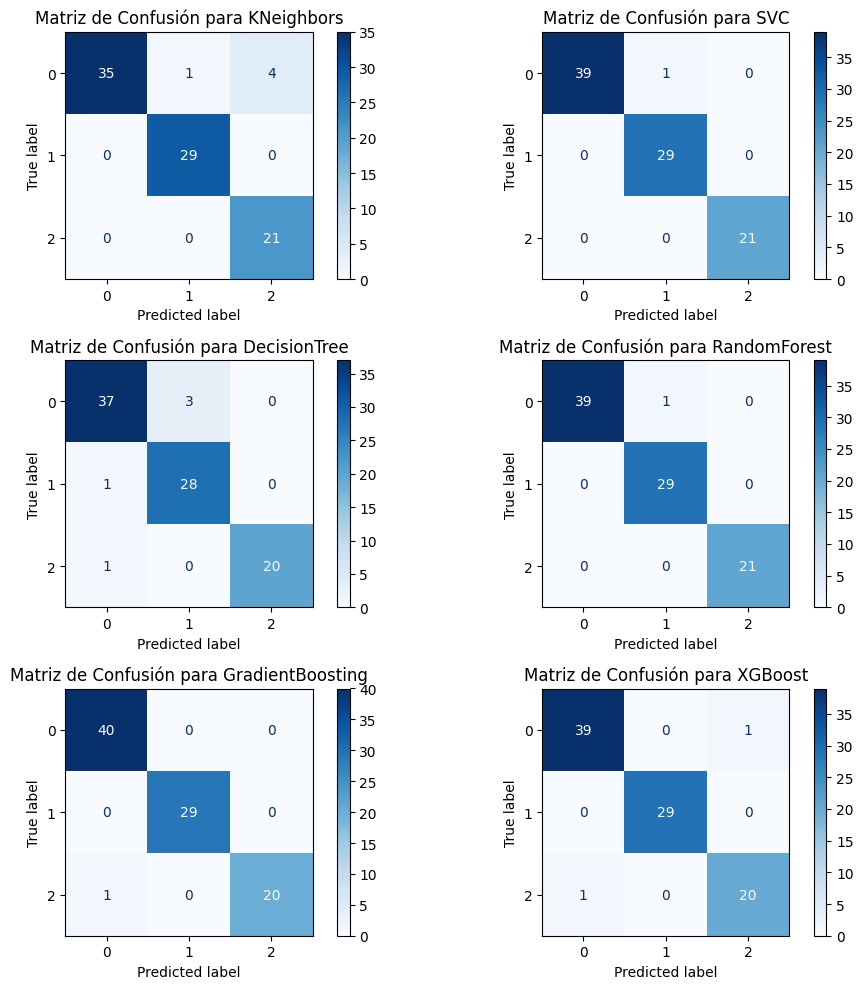

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generar y mostrar las matrices de confusión en subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

for idx, (name, cm) in enumerate(confusion_matrices.items()):
    row = idx // 2
    col = idx % 2
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train_inversed))
    disp.plot(cmap='Blues', ax=axes[row, col])
    axes[row, col].set_title(f'Matriz de Confusión para {name}')

plt.tight_layout()
plt.show()

#Análsis de las caracteristicas

In [34]:
X = df_filt1.drop(columns=['UCI_TIME', 'Survival Rate', 'subject_id'])
y = df1['UCI_TIME']


# Estandarizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Aplicar SMOTE Tomek para sobremuestrear las clases minoritarias y limpiar los ejemplos
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42, smote=SMOTE(k_neighbors=2))
X_resampled, y_resampled = smote_tomek.fit_resample(X_scaled, y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=0)

# Clasificación con SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        73
           1       0.93      1.00      0.96        89
           2       1.00      1.00      1.00        80

    accuracy                           0.97       242
   macro avg       0.98      0.97      0.97       242
weighted avg       0.97      0.97      0.97       242



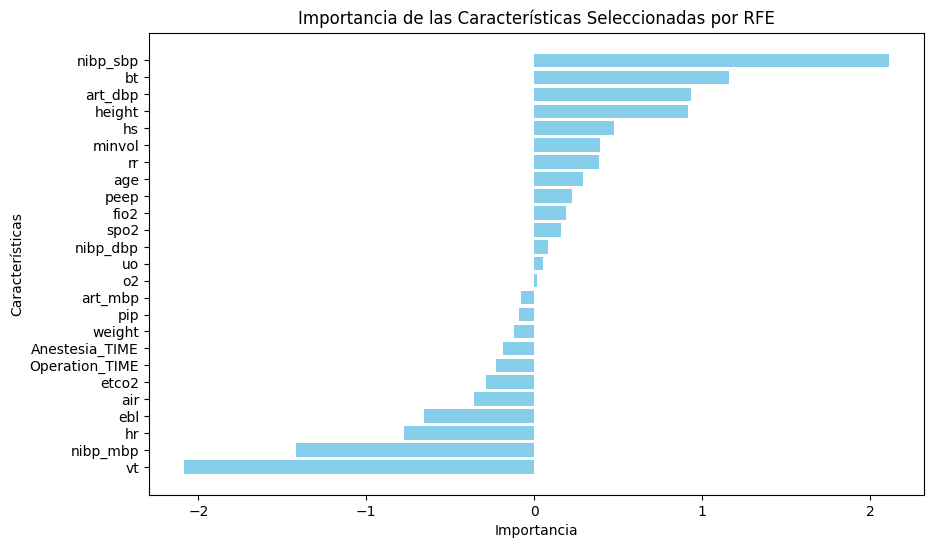

In [35]:


from sklearn.feature_selection import RFE


# Aplicar RFE
rfe = RFE(estimator=svm_model, n_features_to_select=30)  # Puedes ajustar el número de características
rfe.fit(X_train, y_train)

# Características seleccionadas e importancias
selected_features = X.columns[rfe.support_]
feature_importances = rfe.estimator_.coef_[0]

# Crear un DataFrame para las características seleccionadas y sus importancias
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Gráfica de barras de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características Seleccionadas por RFE')
plt.gca().invert_yaxis()
plt.show()

<ipython-input-32-7b094bcaab6e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


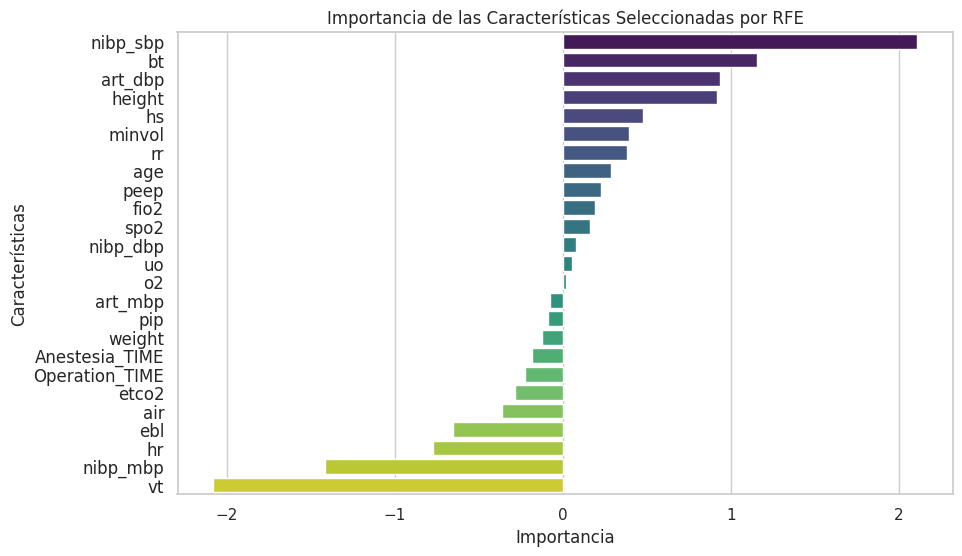

In [ ]:
import seaborn as sns
sns.set(style="whitegrid")
# Crear un DataFrame para las características seleccionadas y sus importancias
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Configurar el estilo y la paleta de colores de seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Crear gráfico de barras con seaborn
bar_plot = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características Seleccionadas por RFE')

# Mejorar la visibilidad de las etiquetas del eje y
for item in bar_plot.get_yticklabels():
    item.set_fontsize(12)

# Mostrar el gráfico
plt.show()
